<a href="https://colab.research.google.com/github/PedroAdair/TesisMaestria/blob/main/Anonimizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Instalación de paqueterias importantes

In [86]:
#@title gower (0.1.2)
!pip install gower 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
#@title networkx
!pip install networkx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
#@title Igraph (1.6.7)
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gower
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import igraph as ig
import networkx as nx

#1. Construcción del grafo

La primer tarea consiste en construir un grafo a partir de la base de datos que se tiene previemente, como nuestros registros contienen observaciones numericas y categoricas, se opta por usar el coeficiente de similitud de Gower.

In [ ]:
#link donde se encuentra la base de datos
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# leer el archivo CSV de la base de datos adult
df = pd.read_csv(url, header=None)

In [ ]:
#Para estos primeros resultados, solo trabajare con n=100
n = 100
df  = df.head(n)

In [ ]:
matriz_distancias = gower.gower_matrix(df)
matriz_distancias

array([[0.        , 0.31261942, 0.31625032, ..., 0.45070857, 0.503844  ,
        0.39384323],
       [0.31261942, 0.        , 0.4071618 , ..., 0.34162003, 0.44175005,
        0.4847547 ],
       [0.31625032, 0.4071618 , 0.        , ..., 0.34806943, 0.36541176,
        0.3442596 ],
       ...,
       [0.45070857, 0.34162003, 0.34806943, ..., 0.        , 0.49986997,
        0.49014324],
       [0.503844  , 0.44175005, 0.36541176, ..., 0.49986997, 0.        ,
        0.576338  ],
       [0.39384323, 0.4847547 , 0.3442596 , ..., 0.49014324, 0.576338  ,
        0.        ]], dtype=float32)

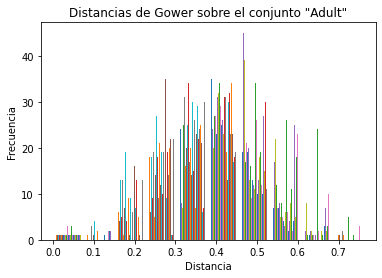

In [ ]:
plt.hist(matriz_distancias)
plt.title('Distancias de Gower sobre el conjunto "Adult"')
plt.xlabel('Distancia')
plt.ylabel('Frecuencia')
plt.show()

Surge aqui un nuevo reto: ¿a partir de que umbral definimos que 2 registros (vértices) tienen una arista en común? 

Creamos un grafo totalmente conectado con $n=100$ vértices y vamos eliminando aquellas aristas que corresponden a los elementos con distancias mayores que obtuvimos en la amtriz de Gower hasta alcanzar una eficiencia global de 0.8.

In [ ]:
#Crea el grafo completo
g = nx.complete_graph(n)
# Obtener umbral correspondiente al percentil 80 de las distancias
threshold = np.percentile(np.sort(matriz_distancias.flatten())[::-1], 60)
print(f"threshold: {threshold}")
# Calcular eficiencia global inicial
efficiency = nx.algorithms.global_efficiency(g)
print(f"Eficiencia inicial: {efficiency}")

threshold: 0.43060379028320306
Eficiencia inicial: 1.0


In [ ]:
# Eliminar aristas cuya distancia sea mayor que el umbral
for u, v in g.edges():
    if matriz_distancias[u][v] > threshold:
        #print(matriz_distancias[u][v])
        g.remove_edge(u, v)

# Calcular eficiencia global
efficiency = nx.algorithms.global_efficiency(g)
# Imprimir la eficiencia global final
print(f"La eficiencia global alcanzada fue de: {efficiency}")

La eficiencia global alcanzada fue de: 0.797407407407407


Finalmente, podemos dibujar el grafo obtenido

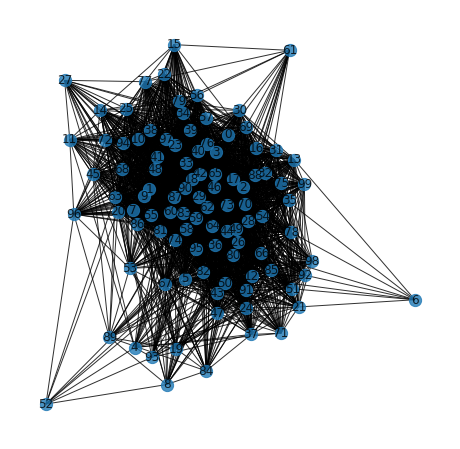

In [ ]:
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g, seed=2023) 
nx.draw_networkx(g, pos=pos, with_labels=True, node_size=150, alpha=0.8, edge_color='k')

plt.axis('off')
plt.show()

In [ ]:
# Obtener número de vértices y aristas
print("Número de vértices:", nx.number_of_nodes(g))
print("Número de aristas:", nx.number_of_edges(g))

Número de vértices: 100
Número de aristas: 2950


Considerando que un grafo totalmento conectado con 100  nodos tiene un total de 4950 aristas, hemos obtenido un grafo que tiene una eficiencia global de 0.8 con 2,000 conecciones menos.

#2. Detección de comunidades

In [ ]:
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

El primer paso antes de aplicar la detección de comunidades, es el de pasar nuestro grafo de networkx a igraph

In [ ]:
G = ig.Graph.from_networkx(g)

A continuación aplicamos 5 métodos para la detección de comunidades, cada uno de ellos posee diferentes caracteristicas que le otorgan una serie de ventajas y desventajas, nuestro objetivo es analizarlos en la tarea de detección de comunidades, los algoritmos son los siguientes:
* Algoritmo de Louvain  `community_multilevel`
* Algoritmo de Infomap `community_infomap`
* Algoritmo de Propagación de la etiqueta  `community_label_propagation`
* Algoritmo de minimización de la energía `community_spinglass` 



##2.1 Algoritmo de Louvain  `community_multilevel`



In [ ]:
# Aplicar el algoritmo de Louvain
Louvain = G.community_multilevel()

# Imprimir la partición del grafo en comunidades
print(Louvain)

Clustering with 100 elements and 3 clusters
[0] 0, 2, 6, 8, 12, 13, 16, 17, 19, 21, 24, 26, 28, 30, 31, 32, 35, 36, 37,
    43, 44, 46, 47, 49, 51, 54, 59, 61, 62, 64, 65, 66, 69, 70, 71, 73, 75,
    78, 80, 84, 85, 88, 89, 91, 92, 95, 98, 99
[1] 1, 3, 7, 9, 10, 11, 14, 15, 18, 20, 22, 23, 25, 27, 29, 33, 34, 38, 39,
    40, 41, 42, 45, 48, 53, 55, 56, 57, 58, 60, 63, 68, 72, 74, 76, 77, 79,
    81, 83, 86, 87, 90, 94, 96, 97
[2] 4, 5, 50, 52, 67, 82, 93


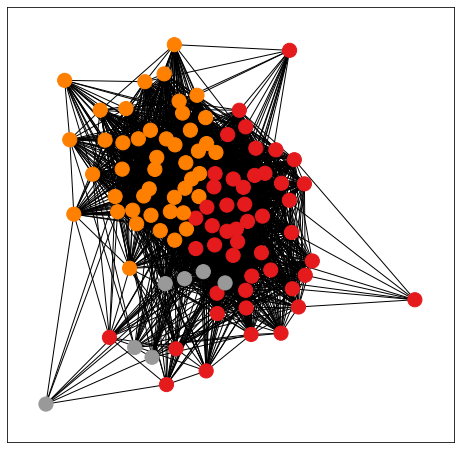

In [ ]:
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g, seed=2023)
nx.draw_networkx_nodes(g, pos, node_size=200, cmap=plt.cm.Set1, node_color=Louvain.membership)
nx.draw_networkx_edges(g, pos)
plt.show()

##2.2  Algoritmo de Infomap `community_infomap`

In [ ]:
# Aplicar el algoritmo de Infomap
Infomap = G.community_infomap()

# Imprimir la partición del grafo en comunidades
print(Infomap)

Clustering with 100 elements and 1 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
    39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
    57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
    75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
    93, 94, 95, 96, 97, 98, 99


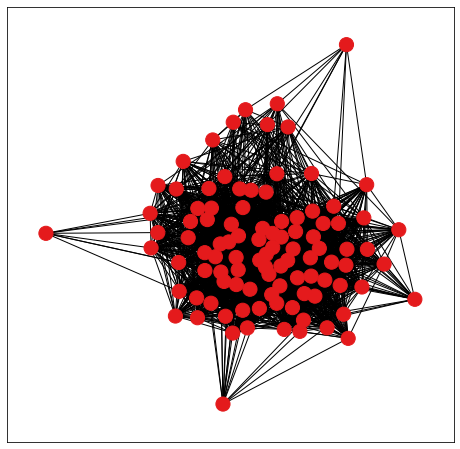

In [ ]:
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, node_size=200, cmap=plt.cm.Set1, node_color=Infomap.membership)
nx.draw_networkx_edges(g, pos)
plt.show()

##2.3 Algoritmo de Propagación de la etiqueta  `community_label_propagation`

In [ ]:
# Aplicar el algoritmo de Propagación de  etiqueta
label_propagation = G.community_label_propagation()

# Imprimir la partición del grafo en comunidades
print(label_propagation)

Clustering with 100 elements and 1 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
    39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
    57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
    75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
    93, 94, 95, 96, 97, 98, 99


##2.4 Algoritmo de minimización de la energía `community_spinglass` 

In [ ]:
# Aplicar el algoritmo de  
spinglass = G.community_spinglass()

# Imprimir la partición del grafo en comunidades
print(spinglass)

Clustering with 100 elements and 3 clusters
[0] 0, 2, 6, 8, 12, 13, 16, 17, 19, 21, 24, 26, 28, 30, 31, 32, 35, 36, 37,
    43, 44, 46, 47, 49, 51, 54, 59, 61, 62, 64, 65, 66, 69, 70, 71, 73, 75,
    78, 80, 84, 85, 88, 89, 91, 92, 95, 98, 99
[1] 1, 3, 7, 9, 10, 11, 14, 15, 18, 20, 22, 23, 25, 27, 29, 33, 34, 38, 39,
    40, 41, 42, 45, 48, 53, 55, 56, 57, 58, 60, 63, 68, 72, 74, 76, 77, 79,
    81, 83, 86, 87, 90, 94, 96, 97
[2] 4, 5, 50, 52, 67, 82, 93


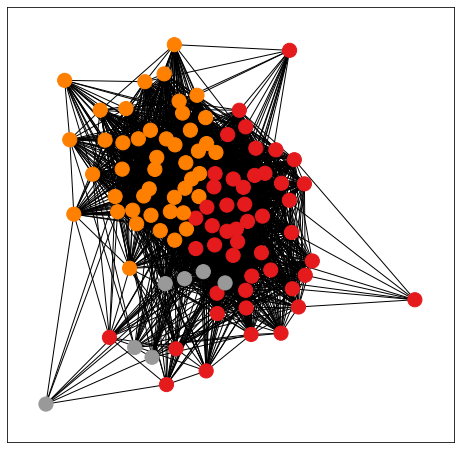

In [ ]:
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g, seed=2023)

nx.draw_networkx_nodes(g, pos, node_size=200, cmap=plt.cm.Set1, node_color=spinglass.membership)
nx.draw_networkx_edges(g, pos)
plt.show()

##2.5 walktrap

In [ ]:
# Aplicar el algoritmo de Walktrap y obtener la partición en comunidades
clustering = G.community_walktrap().as_clustering()

# Obtener la pertenencia de cada nodo a cada comunidad
membership = clustering.membership
print(membership)

[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0]


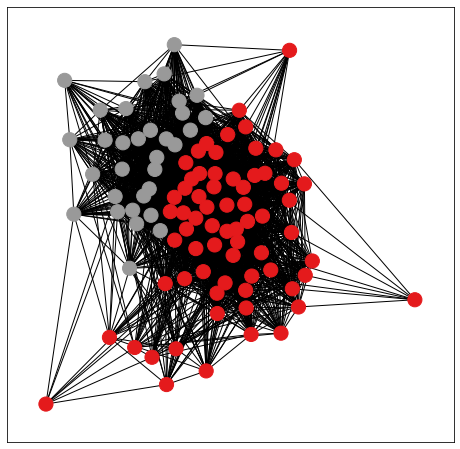

In [ ]:
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g, seed=2023)

nx.draw_networkx_nodes(g, pos, node_size=200, cmap=plt.cm.Set1, node_color=membership)
nx.draw_networkx_edges(g, pos)
plt.show()

#3. Comparación de comunidades

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score, rand_score

In [ ]:
karate = ig.Graph.Famous('Zachary')

A continuación una lista donde enumero los algoritmos para la detección de comunidades que estan implementados en la función `compare_communities()`, recibe como entrada un grafo y 2 numeros correspondientes a los siguientes métodos, devuele el índice Rand ajustado entre las comunidades detectadas por ambos métodos.
* 1. `community_multilevel() `
* 2. `community_infomap() `
* 3. `community_label_propagation() `
* 4. `community_spinglass() `
* 5. `community_walktrap() `

In [ ]:
def compare_communities(graph, method1, method2):
    """
    Calcula el índice Rand entre dos detecciones de comunidades en un grafo.

    Parameters:
    -----------
    graph : igraph.Graph
        Un objeto de grafo de igraph.
    method1 : str
        El nombre de un método de detección de comunidades de igraph, por ejemplo "community_fastgreedy".
    method2 : str
        El nombre de otro método de detección de comunidades de igraph.

    Returns:
    --------
    float
        El índice Rand entre las detecciones de comunidades utilizando los dos métodos.
    """
    if method1 == 1:
      # Realizar la detección de comunidades del primer método
      c1 = graph.community_multilevel().membership
    elif method1 == 2:
      #community_infomap
      c1 = graph.community_infomap().membership
    elif method1 == 3:
      #community_label_propagation
      c1 = graph.community_label_propagation().membership
    elif method1 == 4:
      #community_spinglass
      c1 = graph.community_spinglass().membership
    else:
      #community_walktrap
      walktrap_dendrogram = graph.community_walktrap()
      c1 = walktrap_dendrogram.as_clustering().membership
    """
   -----------------------------------------------------------------------
    """
    if method2 == 1:
      # Realizar la detección de comunidades utilizando los dos métodos
      c2 = graph.community_multilevel().membership
    elif method2 == 2:
      #community_infomap
      c2 = graph.community_infomap().membership
    elif method2 == 3:
      #community_label_propagation
      c2 = graph.community_label_propagation().membership
    elif method2 == 4:
      #community_spinglass
      c2 = graph.community_spinglass().membership
    else:
      #community_walktrap
      walktrap_dendrogram = graph.community_walktrap()
      c2 = walktrap_dendrogram.as_clustering().membership
    # Calcular el índice Rand entre las detecciones de comunidades

    rand_index = adjusted_rand_score(c1, c2)

    return rand_index

In [ ]:
compare_communities(karate,1,1)

0.8653018103820851

In [106]:
import numpy as np

#La primer etapa consiste en crear los "bloques" en las matrices de adyacencia que corresponen a las comunidades,
#las conecciones se realizan basados en una distribución 
def crear_matrices_adyacencia(lista):
    matrices = []
    for n in lista:
        m = np.random.randint(2, size=(n, n))
        np.fill_diagonal(m, 0)
        matriz_adyacencia = np.triu(m, k=1) + np.triu(m, k=1).T
        matrices.append(matriz_adyacencia)
    return matrices

#Posteriormente se unen estos bloques en una sola matriz y los bloques fuera de la diagonal se agregan conecciones 
#basados en una distribución binomial con parametro "p"
def unir_matrices_adyacencia(matrices, p):
    n = len(matrices)
    bloques = []
    for i in range(n):
        fila = []
        for j in range(n):
            if i == j:
                fila.append(matrices[i])
            else:
                fila.append(np.zeros((len(matrices[i]), len(matrices[j]))))
        bloques.append(np.hstack(fila))
    matriz_completa = np.vstack(bloques)

    # Agregar valores de p simétricos fuera de los bloques diagonales
    for i in range(n):
        for j in range(i+1, n):
            filas = slice(sum([len(m) for m in matrices[:i]]), sum([len(m) for m in matrices[:i+1]]))
            columnas = slice(sum([len(m) for m in matrices[:j]]), sum([len(m) for m in matrices[:j+1]]))
            simetrico = np.random.binomial(1, p, (len(matrices[i]), len(matrices[j])))
            matriz_completa[filas, columnas] = simetrico
            matriz_completa[columnas, filas] = simetrico.T

    return matriz_completa

In [124]:
lista = [2, 3, 4]
matrices = crear_matrices_adyacencia(lista)

[array([[0, 1],
       [1, 0]]), array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), array([[0, 0, 1, 1],
       [0, 0, 1, 1],
       [1, 1, 0, 1],
       [1, 1, 1, 0]])]


In [125]:
def unir_matrices_adyacencia(matrices, p):
    n = len(matrices)
    bloques = []
    for i in range(n):
        fila = []
        for j in range(n):
            if i == j:
                fila.append(matrices[i])
            else:
                fila.append(np.zeros((len(matrices[i]), len(matrices[j]))))
        bloques.append(np.hstack(fila))
    matriz_completa = np.vstack(bloques)

    # Agregar valores de p simétricos fuera de los bloques diagonales
    for i in range(n):
        for j in range(i+1, n):
            filas = slice(sum([len(m) for m in matrices[:i]]), sum([len(m) for m in matrices[:i+1]]))
            columnas = slice(sum([len(m) for m in matrices[:j]]), sum([len(m) for m in matrices[:j+1]]))
            simetrico = np.random.binomial(1, p, (len(matrices[i]), len(matrices[j])))
            matriz_completa[filas, columnas] = simetrico
            matriz_completa[columnas, filas] = simetrico.T

    return matriz_completa


In [142]:
matriz_adyacencia = unir_matrices_adyacencia(matrices, 0.3)

In [143]:
matriz_adyacencia

array([[0., 1., 0., 1., 1., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 1., 1.],
       [1., 1., 0., 1., 0., 1., 1., 0., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 0.]])

In [153]:
def from_matrix_to_Grahp(matriz_adyacencia):
  """
  recibe una matriz de adyacencia  y construye en grafo
  """
  # Crear un objeto Grafo vacío
  grafo = nx.Graph()

  # Agregar nodos al grafo
  nodos = range(matriz_adyacencia.shape[0])
  grafo.add_nodes_from(nodos)

  # Agregar enlaces al grafo
  for i in range(matriz_adyacencia.shape[0]):
      for j in range(matriz_adyacencia.shape[1]):
          if matriz_adyacencia[i][j] == 1:
              grafo.add_edge(i, j) 
  return(grafo) 
  

In [155]:
G_ejemplo = from_matrix_to_Grahp(matriz_adyacencia)

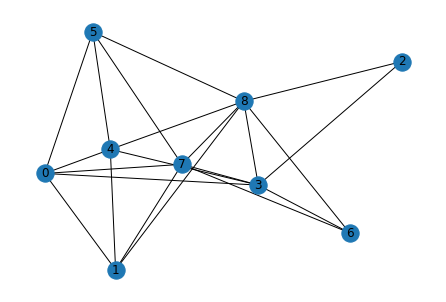

In [158]:
nx.draw(G_ejemplo, with_labels=True)